<a href="https://colab.research.google.com/github/cantagallosabrina-cmyk/Progetto_IA_II/blob/main/Support2_classificazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SUPPORT 2 - CLASSIFICAZIONE

Marta Tognaccini, 2085270

Sabrina Cantagallo, 2092363

##1)ANALISI ESPLORATIVA DEI DATI

In [ ]:
#MONTARE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IMPORT DELLE LIBRERIE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import gaussian_kde

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate
)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    roc_curve
)


In [ ]:
#LOAD DEL DATASET

df = pd.read_csv("/content/drive/MyDrive/Università/Intelligenza_Artificiale_II/PROGETTO/support2.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df.head()

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,NaN,7.000000,other,33.898438,20.0,0.262939,0.036995,1,0,0,metastatic,0.50,0.25,no dnr,5.0,97.0,6.000000,69.0,22.0,36.00000,388.00000,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,NaN,29.000000,white,52.695312,74.0,0.001000,0.000000,3,0,0,no,0.00,0.00,NaN,NaN,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,NaN,NaN,13.000000,white,20.500000,45.0,0.790894,0.664917,4,0,0,no,0.75,0.50,no dnr,17.0,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,NaN,NaN,7.000000,white,20.097656,19.0,0.698975,0.411987,1,0,0,metastatic,0.90,0.50,no dnr,3.0,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,50127.0,NaN,NaN,18.666656,white,23.500000,30.0,0.634888,0.532959,3,0,0,no,0.90,0.90,no dnr,16.0,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


In [ ]:
#RIMOZIONE PRELIMINARE DELLE COLONNE CON DATA LEAKAGE

leakage_vars = [
    "death", "hospdead", "slos", # Derivate dall'esito (morte o durata ricovero)

    "hday", # Derivate dal follow-up e dalla sopravvivenza

    "charges", "totcst", "totmcst", # Costi accumulati durante la degenza (derivano dal tempo sopravvissuto)

    "dnr", "dnrday", # Decisioni cliniche che avvengono durante il ricovero (non note all'inizio)

    "surv2m", "surv6m", "prg2m", "prg6m",  # Variabili che sono esse stesse modelli predittivi della sopravvivenza

    "sps" # Score prognostici calcolati dal team SUPPORT (non validi per il modello)
]

df_clean = df.drop(columns=leakage_vars)

print("Forma del dataframe originale:", df.shape)
print("Forma del dataframe pulito:", df_clean.shape)

df_clean.head()

Forma del dataframe originale: (9105, 47)
Forma del dataframe pulito: (9105, 33)


,age,sex,d.time,dzgroup,dzclass,num.co,edu,income,scoma,avtisst,race,aps,diabetes,dementia,ca,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,male,2029,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,7.000000,other,20.0,0,0,metastatic,97.0,6.000000,69.0,22.0,36.00000,388.00000,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,female,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,29.000000,white,74.0,0,0,no,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,female,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,13.000000,white,45.0,0,0,no,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,female,133,Lung Cancer,Cancer,2,11.0,under $11k,0.0,7.000000,white,19.0,0,0,metastatic,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,female,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,18.666656,white,30.0,0,0,no,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


In [ ]:
df_clean.describe()

,age,d.time,num.co,edu,scoma,avtisst,aps,diabetes,dementia,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
count,9105.000000,9105.000000,9105.000000,7471.000000,9104.000000,9023.000000,9104.000000,9105.000000,9105.000000,9104.000000,8893.000000,9104.000000,9104.000000,9104.000000,6780.000000,5733.000000,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,3464.000000,6238.000000,9105.000000
mean,62.650823,478.449863,1.868644,11.747691,12.058546,22.610928,37.597979,0.195277,0.032510,84.546408,12.347677,97.156711,23.330294,37.103341,239.529070,2.950520,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.157910,1.637384,1.888272
std,15.593710,560.383272,1.344409,3.447743,24.636694,13.233248,19.903852,0.396436,0.177359,27.687692,9.266329,31.559292,9.573801,1.251796,109.665593,0.875944,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,1.739672,2.231358,2.003763
min,18.041990,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,52.797000,26.000000,1.000000,10.000000,0.000000,12.000000,23.000000,0.000000,0.000000,63.000000,7.000000,72.000000,18.000000,36.195310,155.093750,2.399902,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000,0.000000,0.000000
50%,64.856990,233.000000,2.000000,12.000000,0.000000,19.500000,34.000000,0.000000,0.000000,77.000000,10.599609,100.000000,24.000000,36.695310,224.000000,2.899902,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,0.000000,1.000000,1.000000
75%,73.998960,761.000000,3.000000,14.000000,9.000000,31.666656,49.000000,0.000000,0.000000,107.000000,15.298828,120.000000,28.000000,38.195310,304.750000,3.599609,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,2.000000,3.000000,3.000000
max,101.847960,2029.000000,9.000000,31.000000,100.000000,83.000000,143.000000,1.000000,1.000000,195.000000,200.000000,300.000000,90.000000,41.695310,890.375000,29.000000,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.000000,7.000000,7.073242


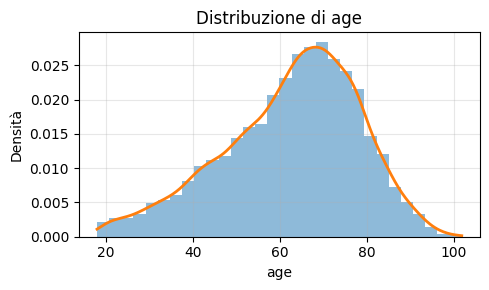

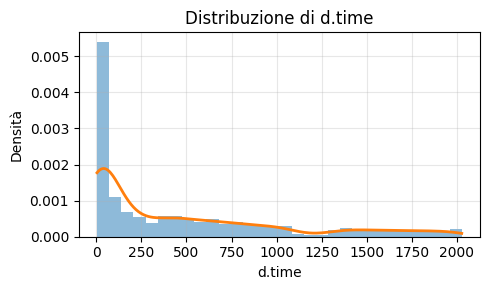

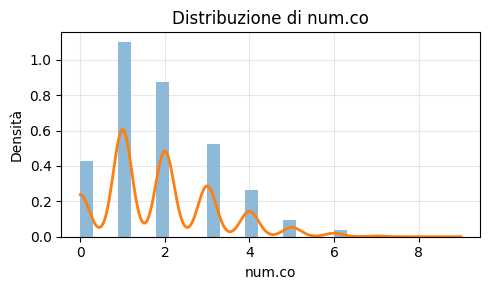

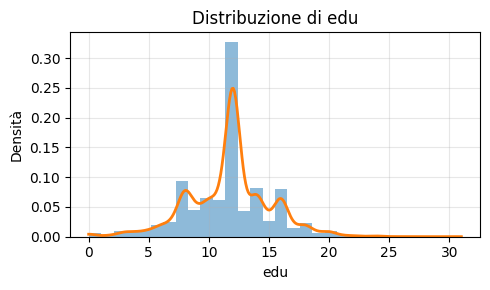

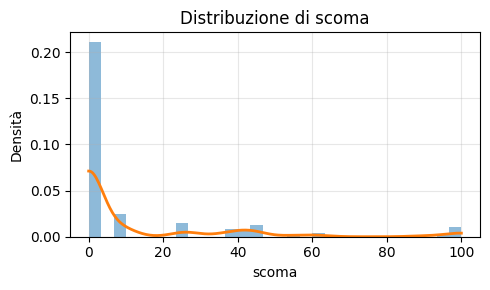

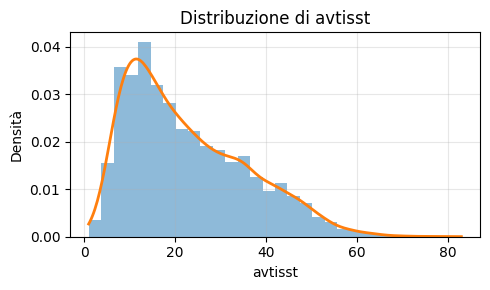

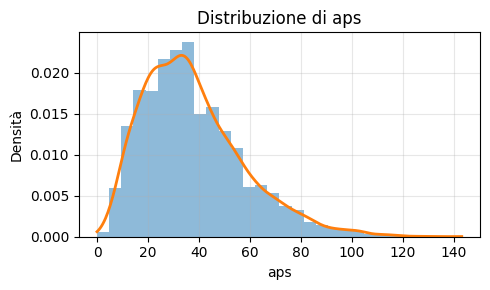

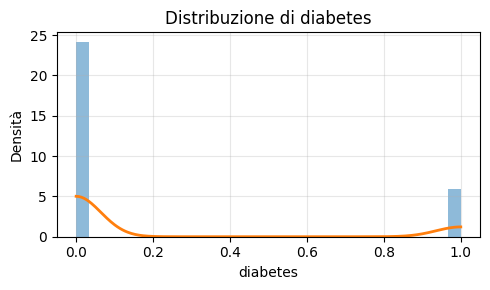

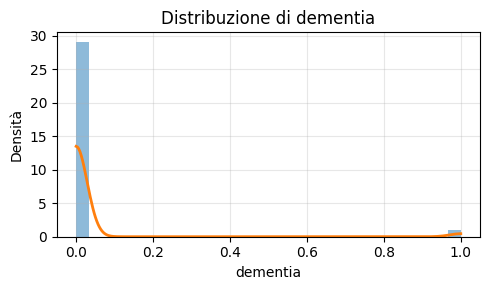

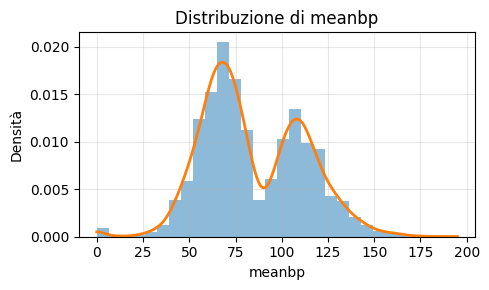

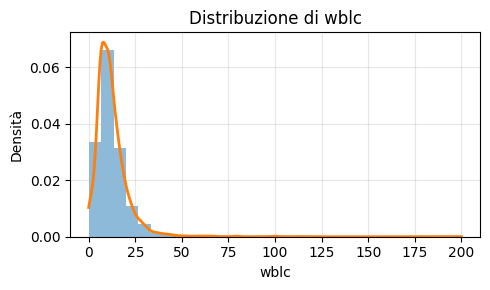

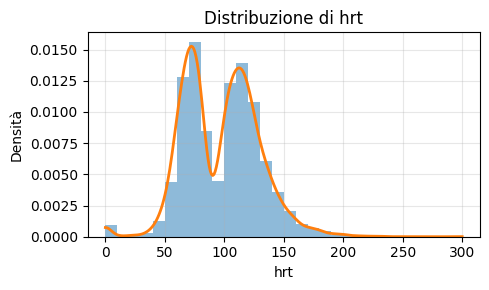

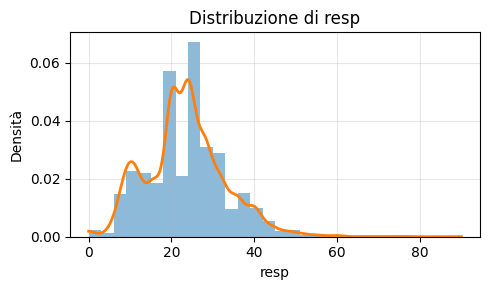

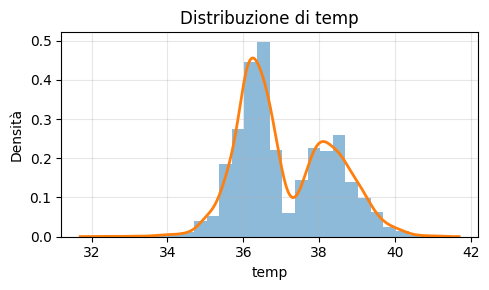

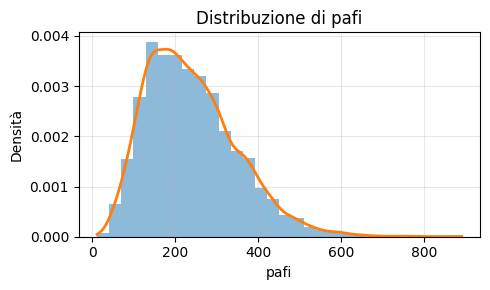

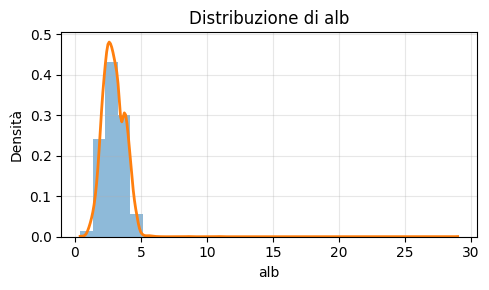

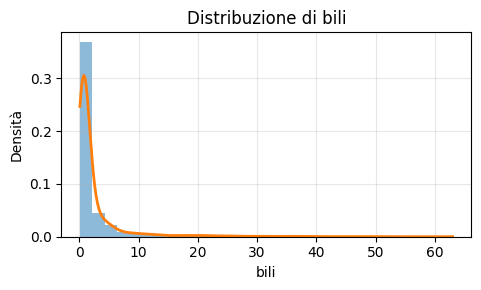

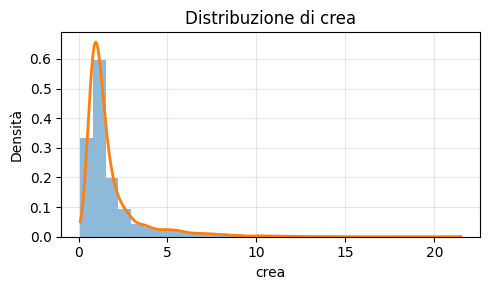

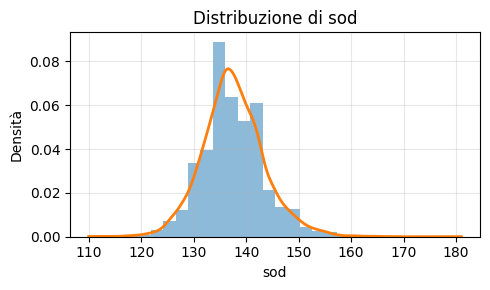

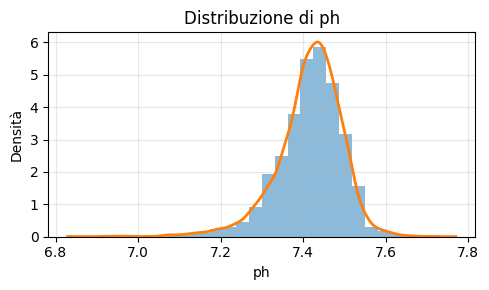

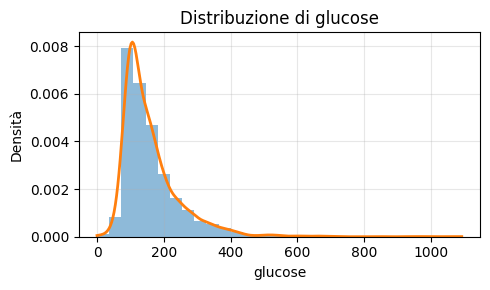

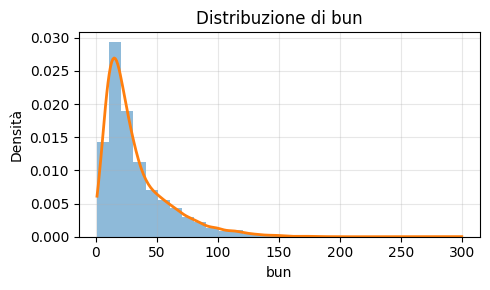

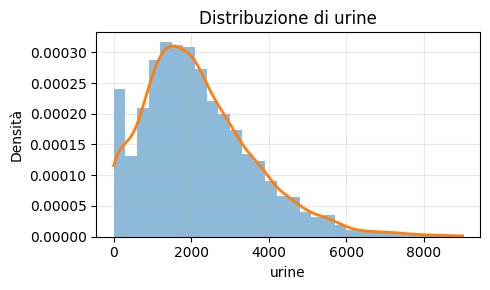

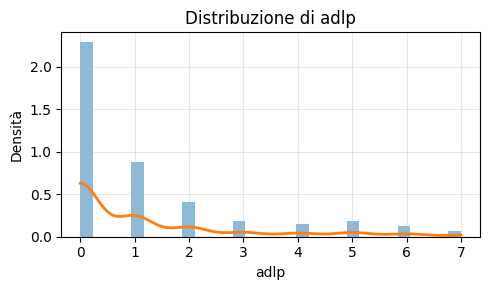

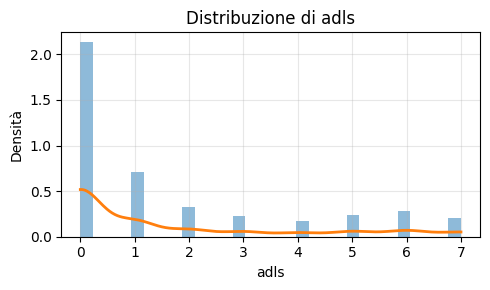

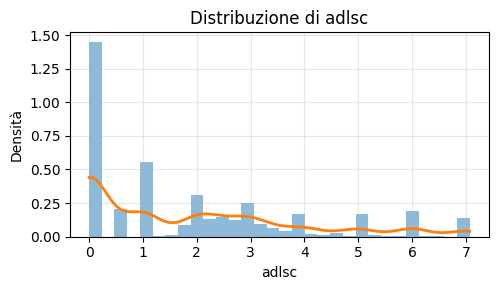

In [ ]:
#DISTRIBUZIONE DELLE VARIABILI NUMERICHE

numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    data = df_clean[col].dropna()

    plt.figure(figsize=(5, 3))

    plt.hist(data, bins=30, density=True, alpha=0.5)

    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 300)
    plt.plot(x_vals, kde(x_vals), linewidth=2)

    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Densità")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


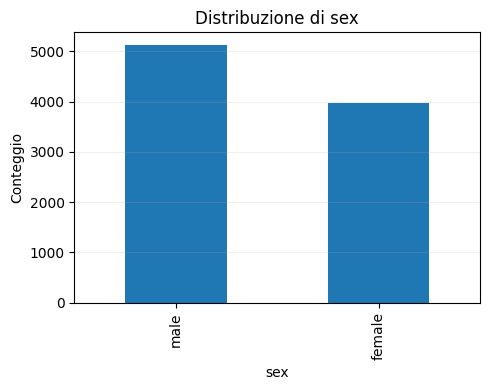

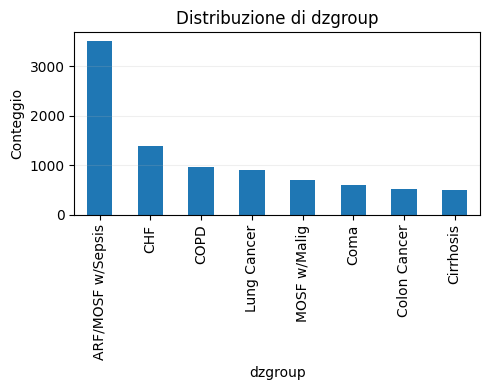

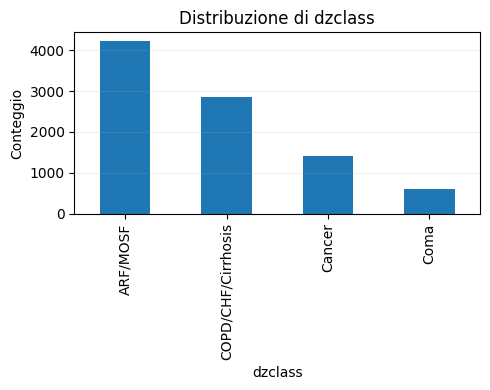

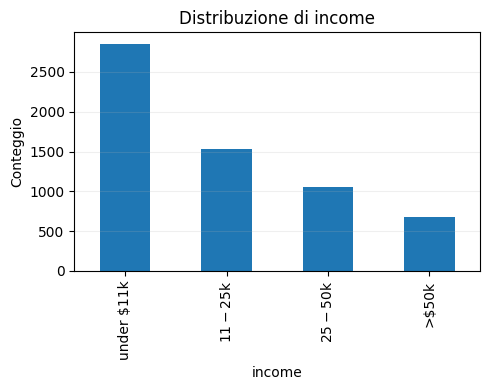

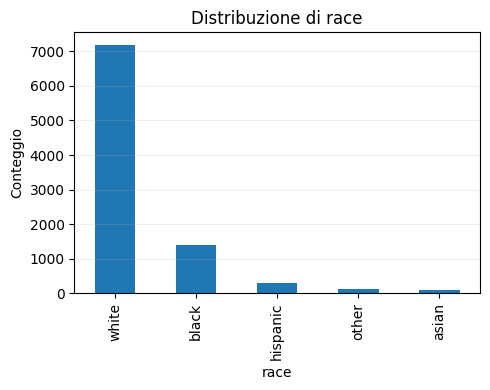

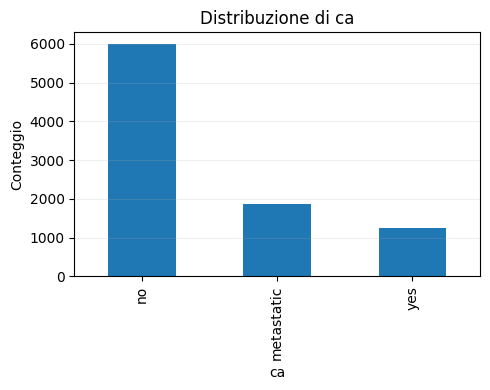

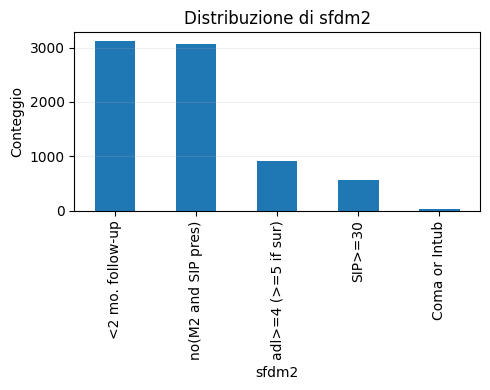

In [ ]:
#FREQUENZA DELLE VARIABILI CATEGORICHE

categorical_cols = df_clean.select_dtypes(exclude=["int64", "float64"]).columns

for col in categorical_cols:
    counts = df_clean[col].value_counts()

    plt.figure(figsize=(5, 4))
    counts.plot(kind="bar")
    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Conteggio")
    plt.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    plt.show()


In [ ]:
#INDIVIDUAZIONE TARGET

df_clean['survive_6m'] = (df_clean['d.time'] > 180).astype(int)

X = df_clean.drop(columns=['d.time', 'survive_6m'])
Y = df_clean['survive_6m']

print(X.columns)
print(Y.head())


Index(['age', 'sex', 'dzgroup', 'dzclass', 'num.co', 'edu', 'income', 'scoma',
       'avtisst', 'race', 'aps', 'diabetes', 'dementia', 'ca', 'meanbp',
       'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod',
       'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'sfdm2', 'adlsc'],
      dtype='object')
1    1
2    0
3    0
4    0
5    1
Name: survive_6m, dtype: int64


(9105, 32)
(9105,)

X e Y hanno gli indici allineati: True

Distribuzione nel dataset del target survive_6m
1    0.531576
0    0.468424
Name: proportion, dtype: float64


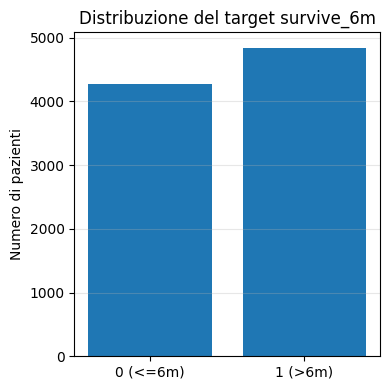

In [ ]:
#CHECK TARGET BALANCE

print(X.shape)
print(Y.shape)

print("\nX e Y hanno gli indici allineati:",X.index.equals(Y.index))

Y.value_counts()
print("\nDistribuzione nel dataset del target" ,Y.value_counts(normalize=True))

counts = df_clean["survive_6m"].value_counts().sort_index()

plt.figure(figsize=(4,4))
plt.bar(["0 (<=6m)", "1 (>6m)"], counts.values)
plt.title("Distribuzione del target survive_6m")
plt.ylabel("Numero di pazienti")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


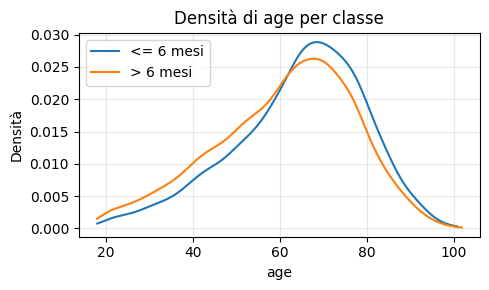

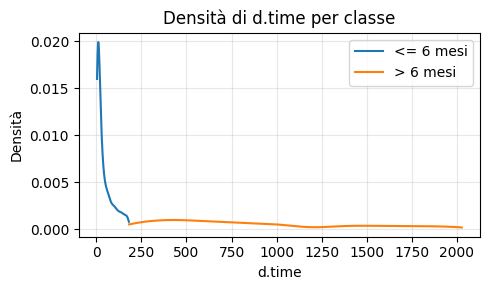

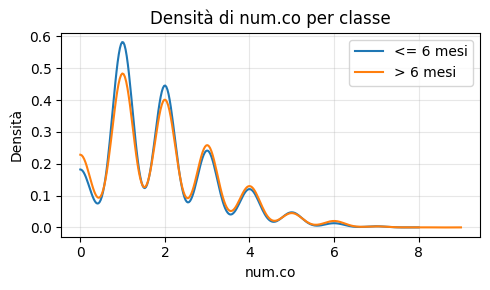

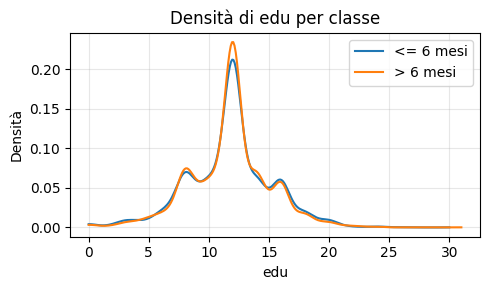

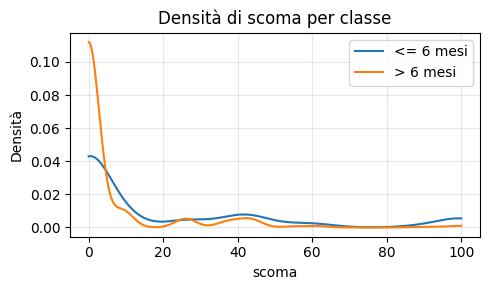

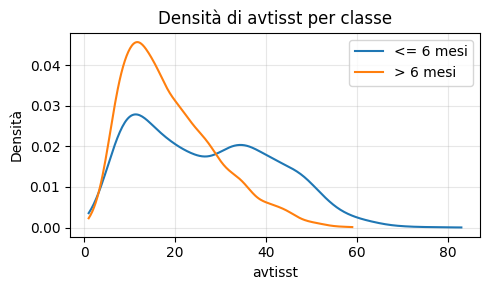

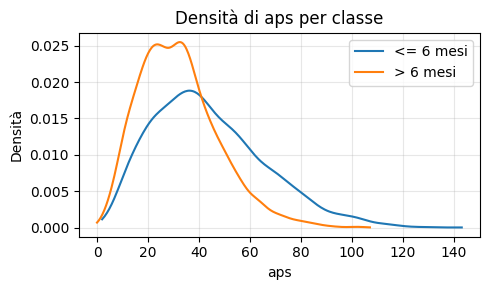

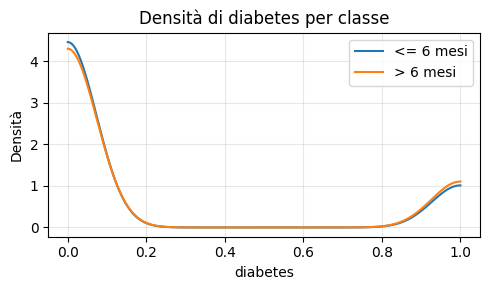

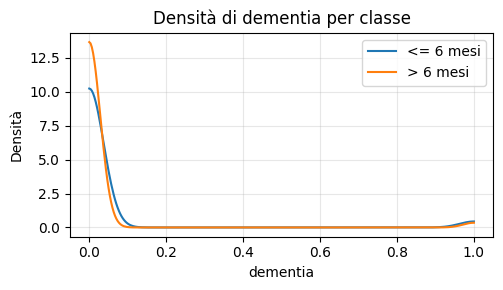

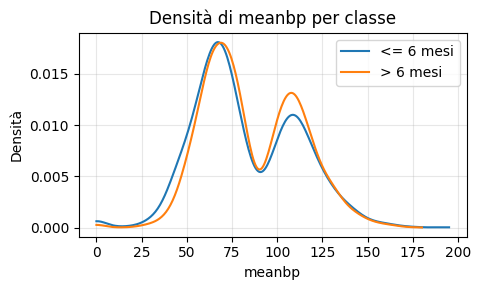

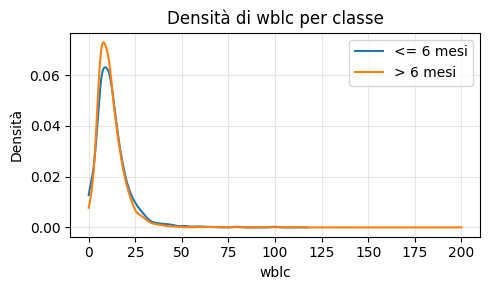

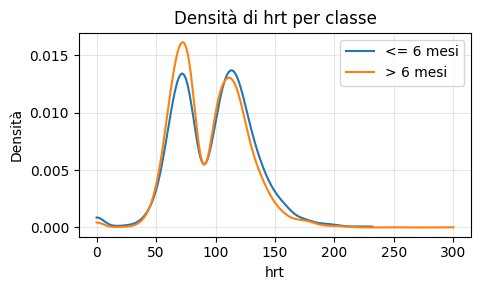

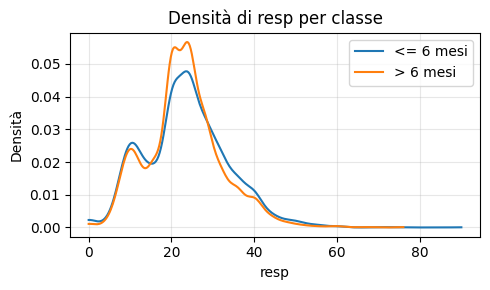

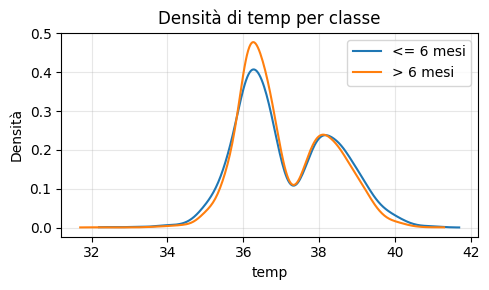

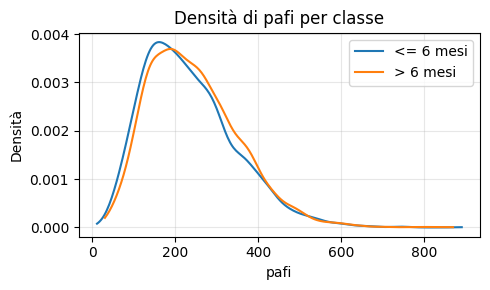

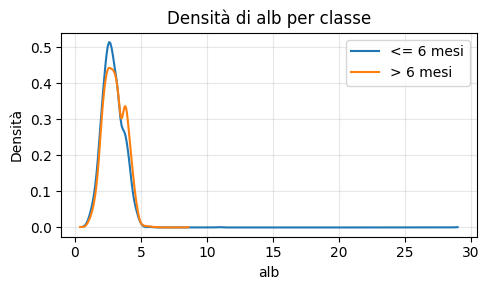

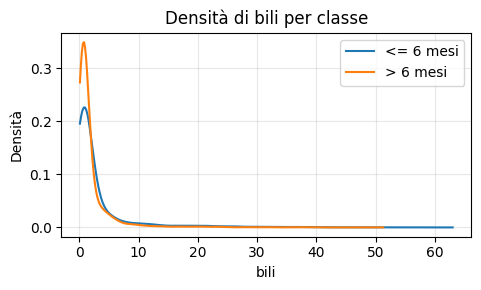

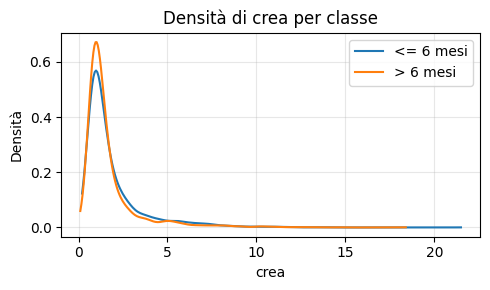

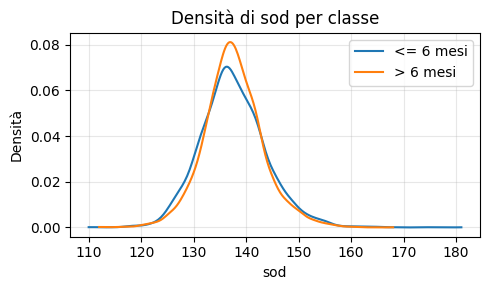

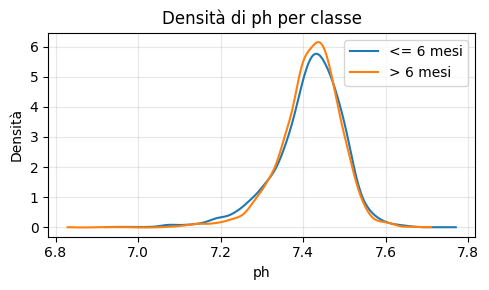

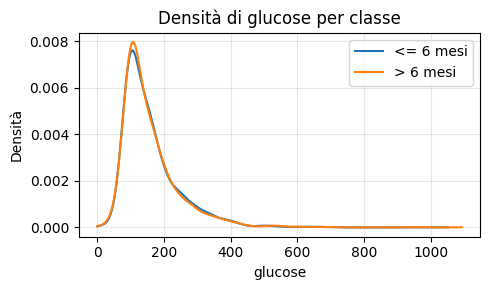

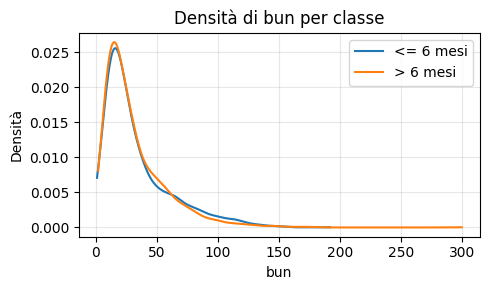

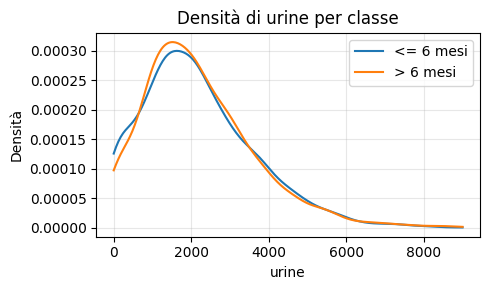

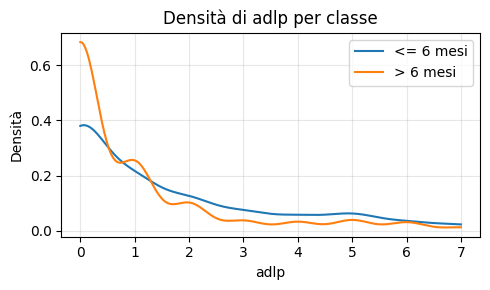

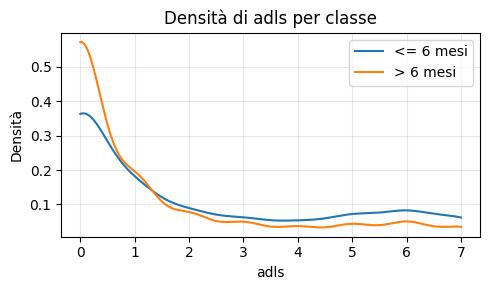

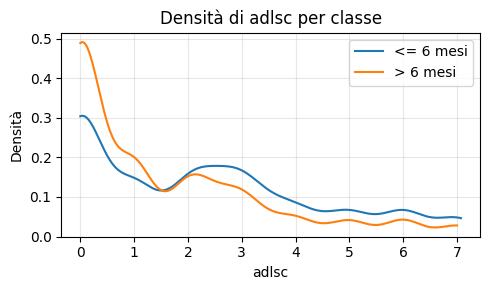

In [ ]:
#CONFRONTO DISTRIBUZIONE VARIABILI NUMERICHE PER CLASSE

for col in numeric_cols:
    plt.figure(figsize=(5, 3))

    for cls, label in [(0, "<= 6 mesi"), (1, "> 6 mesi")]:
        data = df_clean.loc[df_clean["survive_6m"] == cls, col].dropna()
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 300)
        plt.plot(x_vals, kde(x_vals), label=label)

    plt.title(f"Densità di {col} per classe")
    plt.xlabel(col)
    plt.ylabel("Densità")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


##2)PREPROCESSING DEI DATI

In [ ]:
#RIMOZIONE COLONNE CON PIU' DEL 40% DI NAN

nan_ratio = X.isna().mean().sort_values(ascending=False)

print(nan_ratio)

threshold = 0.40
cols_too_empty = nan_ratio[nan_ratio > threshold].index.tolist()

print("Colonne da rimuovere perché troppo vuote:", cols_too_empty)

X = X.drop(columns=cols_too_empty)

print("\nForma del dataframe con colonne vuote rimosse:", X.shape)


adlp        0.619550
urine       0.533992
glucose     0.494234
bun         0.477979
alb         0.370346
income      0.327512
adls        0.314882
bili        0.285667
pafi        0.255354
ph          0.250851
edu         0.179462
sfdm2       0.153762
wblc        0.023284
avtisst     0.009006
crea        0.007359
race        0.004613
meanbp      0.000110
scoma       0.000110
aps         0.000110
temp        0.000110
sod         0.000110
hrt         0.000110
resp        0.000110
num.co      0.000000
dementia    0.000000
ca          0.000000
diabetes    0.000000
age         0.000000
dzclass     0.000000
dzgroup     0.000000
sex         0.000000
adlsc       0.000000
dtype: float64
Colonne da rimuovere perché troppo vuote: ['adlp', 'urine', 'glucose', 'bun']

Forma del dataframe con colonne vuote rimosse: (9105, 28)


In [ ]:
#IMPUTAZIONE CON LA MEDIA DEI VALORI NAN (colonne numeriche)

numeric_cols = X.select_dtypes(include=['int64','float64']).columns

print("Variabili numeriche:", numeric_cols)

for col in numeric_cols:
    X.loc[:, col] = X[col].fillna(X[col].mean())


Variabili numeriche: Index(['age', 'num.co', 'edu', 'scoma', 'avtisst', 'aps', 'diabetes',
       'dementia', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb',
       'bili', 'crea', 'sod', 'ph', 'adls', 'adlsc'],
      dtype='object')


In [ ]:
#IMPUTAZIONE CON LA MODA DEI VALORI NAN (colonne non numeriche)

categorical_cols = X.columns.difference(numeric_cols)

print("Variabili non numeriche:", categorical_cols)

for col in categorical_cols:
    if X[col].isna().sum() > 0:
        moda = X[col].mode()[0]
        X[col] = X[col].fillna(moda)


Variabili non numeriche: Index(['ca', 'dzclass', 'dzgroup', 'income', 'race', 'sex', 'sfdm2'], dtype='object')


In [ ]:
#CONTROLLO ASSENZA VALORI NAN

print(X.isna().sum().sum())


0


In [ ]:
#DUMMIFICAZIONE DELLE VARIABILI CATEGORICHE

#sex
X["sex"] = X["sex"].map({"male": 0, "female": 1}).astype(int)

#ca
X["ca"] = X["ca"].map({"yes": 1, "no": 0,"metastatic":2}).astype(int)

#dzclass
X["dzclass"] = X["dzclass"].map({"ARF/MOSF":1, "COPD/CHF/Cirrhosis":2, "Cancer":3, "Coma":4}).astype(int)

#dzgroup
X["dzgroup"] = X["dzgroup"].map({"ARF/MOSF w/Sepsis":1, "CHF":2, "COPD":3, "Cirrhosis":4, "Colon Cancer":5, "Coma":6, "Lung Cancer":7, "MOSF w/Malig":8}).astype(int)

#income
X["income"] = X["income"].map({"under $11k":1,"$11-$25k":2, "$25-$50k":3, ">$50k":4}).astype(int)

#race
X["race"] = X["race"].map({"white":1, "asian":2, "black":3, "hispanic":4, "missing":0, "other":5}).astype(int)

#sfdm2
X["sfdm2"] = X["sfdm2"].map({"no(M2 and SIP pres)":1, "adl>=4 (>=5 if sur)":2, "SIP>=30":3, "Coma or Intub":4,"<2 mo. follow-up":5}).astype(int)

X.head()

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,avtisst,race,aps,diabetes,dementia,ca,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,adls,sfdm2,adlsc
1,62.84998,0,7,3,0,11.000000,2,0.0,7.000000,5,20.0,0,0,2,97.0,6.000000,69.0,22.0,36.00000,388.00000,1.799805,0.199982,1.199951,141.0,7.459961,7.0,5,7.0
2,60.33899,1,4,2,2,12.000000,2,44.0,29.000000,1,74.0,0,0,0,43.0,17.097656,112.0,34.0,34.59375,98.00000,2.950520,2.554463,5.500000,132.0,7.250000,1.0,5,1.0
3,52.74698,1,4,2,2,12.000000,1,0.0,13.000000,1,45.0,0,0,0,70.0,8.500000,88.0,28.0,37.39844,231.65625,2.950520,2.199707,2.000000,134.0,7.459961,0.0,5,0.0
4,42.38498,1,7,3,2,11.000000,1,0.0,7.000000,1,19.0,0,0,2,75.0,9.099609,88.0,32.0,35.00000,239.52907,2.950520,2.554463,0.799927,139.0,7.415364,0.0,1,0.0
5,79.88495,1,1,1,1,11.747691,1,26.0,18.666656,1,30.0,0,0,0,59.0,13.500000,112.0,20.0,37.89844,173.31250,2.950520,2.554463,0.799927,143.0,7.509766,2.0,1,2.0


In [ ]:
#NORMALIZZAZIONE DELLE X

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X.head()

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,avtisst,race,aps,diabetes,dementia,ca,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,adls,sfdm2,adlsc
1,0.012772,0,7,3,-1.390013,-0.239424,2,-0.489508,-1.185089,5,-0.884247,-0.492609,-0.183308,2,0.449837,-0.693182,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,-0.339941,0.569191,6.396077e-01,2.903752,5,2.551205
2,-0.148262,1,4,2,0.097711,0.080794,2,1.296642,0.485020,1,1.829094,-0.492609,-0.183308,0,-1.500702,0.518710,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,2.220019,-0.923678,-2.371651e+00,-0.345131,5,-0.443326
3,-0.635153,1,4,2,0.097711,0.080794,1,-0.489508,-0.729604,1,0.371930,-0.492609,-0.183308,0,-0.525432,-0.420176,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,0.136355,-0.591929,6.396077e-01,-0.886611,5,-0.942415
4,-1.299688,1,7,3,0.097711,-0.239424,1,-0.489508,-1.185089,1,-0.934494,-0.492609,-0.183308,2,-0.344827,-0.354697,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,-0.578088,0.237442,-1.273825e-14,-0.886611,1,-0.942415
5,1.105258,1,1,1,-0.646151,0.000000,1,0.565944,-0.299426,1,-0.381776,-0.492609,-0.183308,0,-0.922764,0.125837,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,-0.578088,0.900939,1.353911e+00,0.196350,1,0.055762


##3)TRAINING DEL MODELLO

In [ ]:
#TRAIN/TEST SET SPLIT

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("\nDistribuzione classi (train):\n", Y_train.value_counts(normalize=True))
print("\nDistribuzione classi (test):\n", Y_test.value_counts(normalize=True))

X_train: (7284, 28) X_test: (1821, 28)

Distribuzione classi (train):
 survive_6m
1    0.531576
0    0.468424
Name: proportion, dtype: float64

Distribuzione classi (test):
 survive_6m
1    0.531576
0    0.468424
Name: proportion, dtype: float64


In [ ]:
#BASELINE: Logistic Regression (fit sul training)

baseline_logreg = LogisticRegression(max_iter=2000)
baseline_logreg.fit(X_train, Y_train)

print("Baseline Logistic Regression allenata (fit su training).")

Baseline Logistic Regression allenata (fit su training).


In [ ]:
#VALUTAZIONE LOG-REG SU TEST SET

Y_pred = baseline_logreg.predict(X_test)
Y_proba = baseline_logreg.predict_proba(X_test)[:, 1]

print("FINAL TEST RESULTS — LOGISTIC REGRESSION")
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("ROC-AUC :", roc_auc_score(Y_test, Y_proba))

print("\nConfusion matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification report:\n", classification_report(Y_test, Y_pred))

FINAL TEST RESULTS — LOGISTIC REGRESSION
Accuracy: 0.8110928061504667
ROC-AUC : 0.8809319078023117

Confusion matrix:
 [[666 187]
 [157 811]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       853
           1       0.81      0.84      0.83       968

    accuracy                           0.81      1821
   macro avg       0.81      0.81      0.81      1821
weighted avg       0.81      0.81      0.81      1821



In [ ]:
#5-FOLD CROSS-VALIDATION --> CONFRONTO TRA MODELLI (LOG-REG, LDA, KNN)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "LDA": LinearDiscriminantAnalysis(),
    "KNN-15": KNeighborsClassifier(n_neighbors=15),
    "KNN-30": KNeighborsClassifier(n_neighbors=30)
}

cv_results = {}

print("CROSS-VALIDATION (5-fold) sul TRAIN:\n")
for name, model in models.items():
    res = cross_validate(model, X_train, Y_train, cv=cv, scoring=scoring, return_train_score=False)
    cv_results[name] = res

    print(f"{name}:")
    for m in scoring.keys():
        mu = np.mean(res[f"test_{m}"])
        sd = np.std(res[f"test_{m}"])
        print(f"  {m.upper():10s}: {mu:.3f} ± {sd:.3f}")
    print()


metrics = ["accuracy", "roc_auc", "precision", "recall", "f1"]
summary_rows = []

for name in models.keys():
    row = {"Model": name}
    for m in metrics:
        row[m.upper()] = np.mean(cv_results[name][f"test_{m}"])
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows).sort_values(by="ROC_AUC", ascending=False)
print("\nRIEPILOGO CV (medie):\n")
print(df_summary.to_string(index=False))


CROSS-VALIDATION (5-fold) sul TRAIN:

LogReg:
  ACCURACY  : 0.813 ± 0.009
  ROC_AUC   : 0.883 ± 0.010
  PRECISION : 0.826 ± 0.013
  RECALL    : 0.822 ± 0.005
  F1        : 0.823 ± 0.007

LDA:
  ACCURACY  : 0.808 ± 0.012
  ROC_AUC   : 0.884 ± 0.011
  PRECISION : 0.835 ± 0.013
  RECALL    : 0.796 ± 0.010
  F1        : 0.815 ± 0.011

KNN-15:
  ACCURACY  : 0.808 ± 0.006
  ROC_AUC   : 0.866 ± 0.008
  PRECISION : 0.792 ± 0.006
  RECALL    : 0.866 ± 0.006
  F1        : 0.827 ± 0.005

KNN-30:
  ACCURACY  : 0.808 ± 0.007
  ROC_AUC   : 0.873 ± 0.010
  PRECISION : 0.800 ± 0.007
  RECALL    : 0.852 ± 0.010
  F1        : 0.825 ± 0.007


RIEPILOGO CV (medie):

 Model  ACCURACY  ROC_AUC  PRECISION   RECALL       F1
   LDA  0.808070 0.883798   0.834938 0.796485 0.815242
LogReg  0.812739 0.883375   0.825578 0.821538 0.823497
KNN-30  0.808209 0.872926   0.800323 0.851759 0.825214
KNN-15  0.807797 0.865799   0.792088 0.865704 0.827251


In [ ]:
#CONFRONTO METRICHE PER SCELTA DEL MODELLO MIGLIORE

metrics_order = ["ROC_AUC", "F1", "RECALL", "PRECISION", "ACCURACY"]
df_rank = df_summary.copy()

for m in metrics_order:
    df_rank[m + "_rank"] = df_rank[m].rank(ascending=False, method="min")

df_rank["RANK_SUM"] = df_rank[[m + "_rank" for m in metrics_order]].sum(axis=1)
print("\nRANKING:\n")
print(df_rank.to_string(index=False))

df_rank_sorted = df_rank.sort_values("RANK_SUM")[["Model"] + metrics_order + ["RANK_SUM"]]
print("\nCONFRONTO COMPLETO (somma dei rank):\n")
print(df_rank_sorted.to_string(index=False))

chosen_model_name = df_rank_sorted.iloc[0]["Model"]
chosen_model = models[chosen_model_name]
print("\nMODELLO SCELTO:", chosen_model_name)
print("Motivazione: migliore modello scelto sulla base della somma dei rank più bassa delle metriche.")



RANKING:

 Model  ACCURACY  ROC_AUC  PRECISION   RECALL       F1  ROC_AUC_rank  F1_rank  RECALL_rank  PRECISION_rank  ACCURACY_rank  RANK_SUM
   LDA  0.808070 0.883798   0.834938 0.796485 0.815242           1.0      4.0          4.0             1.0            3.0      13.0
LogReg  0.812739 0.883375   0.825578 0.821538 0.823497           2.0      3.0          3.0             2.0            1.0      11.0
KNN-30  0.808209 0.872926   0.800323 0.851759 0.825214           3.0      2.0          2.0             3.0            2.0      12.0
KNN-15  0.807797 0.865799   0.792088 0.865704 0.827251           4.0      1.0          1.0             4.0            4.0      14.0

CONFRONTO COMPLETO (somma dei rank):

 Model  ROC_AUC       F1   RECALL  PRECISION  ACCURACY  RANK_SUM
LogReg 0.883375 0.823497 0.821538   0.825578  0.812739      11.0
KNN-30 0.872926 0.825214 0.851759   0.800323  0.808209      12.0
   LDA 0.883798 0.815242 0.796485   0.834938  0.808070      13.0
KNN-15 0.865799 0.827251 0.865

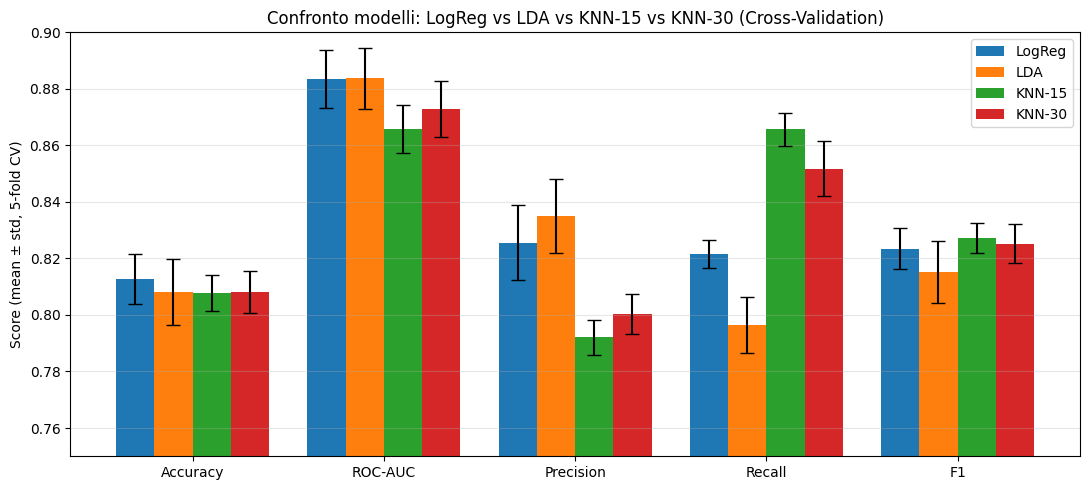

In [ ]:
#GRAFICO CONFROTO METRICHE

metrics = ["accuracy", "roc_auc", "precision", "recall", "f1"]
labels  = ["Accuracy", "ROC-AUC", "Precision", "Recall", "F1"]

models_cv = cv_results

model_names = list(models_cv.keys())
means = {name: [np.mean(models_cv[name][f"test_{m}"]) for m in metrics] for name in model_names}
stds  = {name: [np.std(models_cv[name][f"test_{m}"])  for m in metrics] for name in model_names}

x = np.arange(len(metrics))

n_models = len(model_names)
group_width = 0.8
bar_width = group_width / n_models

plt.figure(figsize=(11, 5))

for i, name in enumerate(model_names):
    offset = (i - (n_models - 1) / 2) * bar_width
    plt.bar(
        x + offset,
        means[name],
        width=bar_width,
        yerr=stds[name],
        capsize=5,
        label=name
    )

plt.xticks(x, labels)
plt.ylabel("Score (mean ± std, 5-fold CV)")
plt.title("Confronto modelli: LogReg vs LDA vs KNN-15 vs KNN-30 (Cross-Validation)")
plt.ylim(0.75, 0.90)  # puoi adattarlo
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#ADDESTRAMENTO MODELLO MIGLIORE

chosen_model.fit(X_train, Y_train)
Y_pred = chosen_model.predict(X_test)

if hasattr(chosen_model, "predict_proba"):
    Y_proba = chosen_model.predict_proba(X_test)[:, 1]
else:
    Y_proba = chosen_model.decision_function(X_test)

print("\nFINAL TEST RESULTS —", chosen_model_name)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("ROC-AUC :", roc_auc_score(Y_test, Y_proba))

print("\nConfusion matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification report:\n", classification_report(Y_test, Y_pred))


FINAL TEST RESULTS — LogReg
Accuracy: 0.8110928061504667
ROC-AUC : 0.8809319078023117

Confusion matrix:
 [[666 187]
 [157 811]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       853
           1       0.81      0.84      0.83       968

    accuracy                           0.81      1821
   macro avg       0.81      0.81      0.81      1821
weighted avg       0.81      0.81      0.81      1821



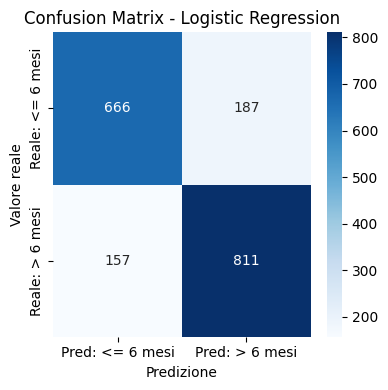

In [ ]:
#CONFUSION MATRIX

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: <= 6 mesi", "Pred: > 6 mesi"],
            yticklabels=["Reale: <= 6 mesi", "Reale: > 6 mesi"])
plt.xlabel("Predizione")
plt.ylabel("Valore reale")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


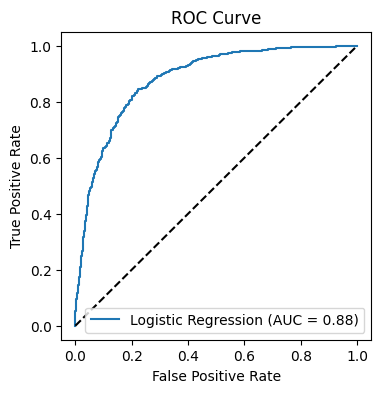

In [ ]:
#ROC-AUC CURVE

fpr, tpr, _ = roc_curve(Y_test, Y_proba)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.2f})".format(roc_auc_score(Y_test, Y_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


##4)CONFRONTO TRA LA PROBABILITA' CALCOLATA DAL NOSTRO MODELLO E LA PROBABILITA' CALCOLATA DAI RICERCATORI

In [ ]:
test_idx = X_test.index

comparison_df = pd.DataFrame({
    "survive_6m_real": Y_test,
    "logreg_proba_survive": chosen_model.predict_proba(X_test)[:, 1],
    "surv6m_dataset": df.loc[test_idx, "surv6m"]
})

comparison_sample = comparison_df.sample(10, random_state=42)
comparison_sample



,survive_6m_real,lda_proba_survive,surv6m_dataset
1943,0,0.104305,0.076996
4994,1,0.934436,0.701904
6235,0,0.176279,0.228973
2328,1,0.570726,0.590942
4569,1,0.888344,0.884888
4405,0,0.099084,0.107986
5867,0,0.071845,0.076996
4699,0,0.235878,0.563965
6142,1,0.975539,0.897949
7407,1,0.163522,0.357971
